# Shapelet based time series machine learning

In this notebook, our goal is to introduce the notions necessary to understand the
use of Shapelets for time series machine learning. We introduce shapelets and give an
 overview of the algorithms under pinning the classifiers before describing specific
 classifiers. There are notebooks on specific shapelet transformers in the
transformers notebook.


In this notebook, we will denote a time series of length $m$ and of dimension $d$ as
a vector $X = [\mathbf{x}_1, \ldots, \mathbf{x}_m]$ with $\mathbf{x}_j \in \mathbb{R}^d$.

In `aeon` we describe a series as `X : (n_channels, n_timepoints)`, where `X` is a two
dimensional array, and `n_channels` correspond to the dimension $d$, or the number
 of features, and `n_timepoints` to $m$, the number of observations. Note that this
 definition implies that we have a fixed time interval between each time point (i.e. a time series with a fixed frequency). When $d=1$, $X$ is said to be univariate, and multivariate when $d>1$.

When talking about a time series collection, we will use the notation ${\cal X} = [X_1,
\ldots, X_n]$, which in code corresponds to a three dimensional array of shape `X : (n_samples, n_channels, n_timepoints)`, with $n$ corresponding to `n_samples`, the number of time series composing the dataset ${\cal X}$.

For example, we can use the GunPoint dataset :


In [3]:
from aeon.datasets import load_classification

X_train, y_train = load_classification("GunPoint", split="train")
X_test, y_test = load_classification("GunPoint", split="test")

print(f"shape of the array: {X_train.shape}")
print(f"n_samples = {X_train.shape[0]}")
print(f"n_channels = {X_train.shape[1]}")
print(f"n_timepoints = {X_train.shape[2]}")

shape of the array: (50, 1, 150)
n_samples = 50
n_channels = 1
n_timepoints = 150


We have the following shapelet based classifiers in `aeon`:

In [4]:
from aeon.utils.discovery import all_estimators

all_estimators("classifier", tag_filter={"algorithm_type": "shapelet"})

[('LearningShapeletClassifier',
  aeon.classification.shapelet_based._ls.LearningShapeletClassifier),
 ('RDSTClassifier', aeon.classification.shapelet_based._rdst.RDSTClassifier),
 ('RSASTClassifier',
  aeon.classification.shapelet_based._rsast.RSASTClassifier),
 ('SASTClassifier', aeon.classification.shapelet_based._sast.SASTClassifier),
 ('ShapeletTransformClassifier',
  aeon.classification.shapelet_based._stc.ShapeletTransformClassifier)]

For the sake of simplicity we assume the following assumptions in the next definitions
- We only consider univariate time series ($d=1$)
- We only consider equal length time series ($m_i = m_j, \ \forall\ i,j \in [1,n] $)

## Definition of a Shapelet
A Shapelet $S$ is defined as a time series subseries of a series in the training data
 that is useful in discriminating between classes. , which is extracted
from a training dataset ${\cal X}^{\ train}$. A shapelet $S$ has a length a  $l$,
where $l<m$. So, given our time series collection, we could create a shapelet candidate
for a channel in the first time series starting at the 45<sup>th</sup> timestamp:
We have the following shapelet based classifiers in `aeon`:


In [21]:
length = 25  # the length of the shapelet
S = X_train[0, 0, 45 : 45 + length]  # Set the shapelet values
print(S)

[-0.64349171 -0.64265061 -0.6420974  -0.64447929 -0.6488921  -0.65765851
 -0.66120325 -0.64966432 -0.61016844 -0.53743483 -0.46503123 -0.35853483
 -0.28313648 -0.17744604  0.15824648  0.35028455  0.48241039  0.60380734
  0.79710411  0.98755132  1.2037853   1.4065415   1.5962459   1.7128307
  1.7788152 ]


In aeon, we expose some visualization classes for shapelets to help create plots and understand what's going on behind the scene. We can for example, visualize the subsequence represented by the shapelet `S`: (note that the following might take a long time to import **for the first time on your system**, as it needs to import all shapelet-based estimators in aeon, with some needing some compilation work due to `numba`)

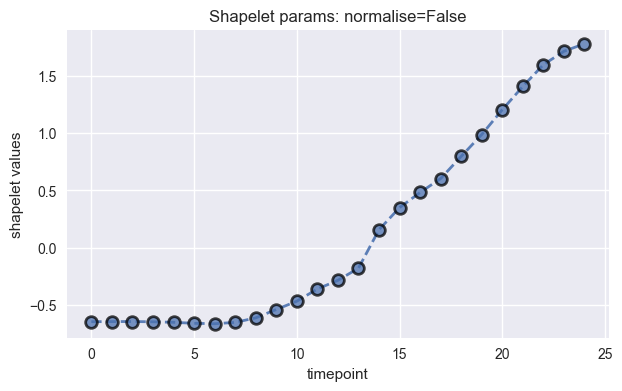

In [22]:
from aeon.visualisation import ShapeletVisualizer

shp_vis = ShapeletVisualizer(S)
fig = shp_vis.plot(figure_options={"figsize": (7, 4)})

Historicaly, shapelets were first proposed as a primitive for time series machine learning [1] and were used as splitting criterion in a decision tree for time series classification. To make this work, a distance $dist$ between a shapelet $S$ and a time series $X$ was defined such as $dist(S,X) \rightarrow \mathbb{R}$. The Shapelet-based splitting criterion was then based on a threshold $\lambda$ on the distance as $dist(S,X) < \lambda$ to direct a time series $X$ to the left or right child node, with each node being defined by another shapelet.

This way of calculating the distance, which is still used today, was to compute the
Euclidean distance between $S$ and all subsequences of size $l$ in $X$, and to return the minimum. More formally :

$\displaystyle{dist(S,X) = \min\limits_{i\ :1, \ldots, m-l+1} \sqrt{\sum_{j=0}^{l-1}(\mathbf{s}_j - \mathbf{x}_{i+j})^2}}$

This represents the idea that the distance of a shapelet to a time series is the distance between the shapelet and the best matching subsequence of the same size in $X$. We can illustrate this formula with the following image, where we would extract the minimum from the values $v$ :

<img src="img/ex_shp_simple.png" alt="drawing" width="500"/>


We can visualize this idea in two ways, first, we can position the shapelet on its best-matching subsequence in a time series $X$ :


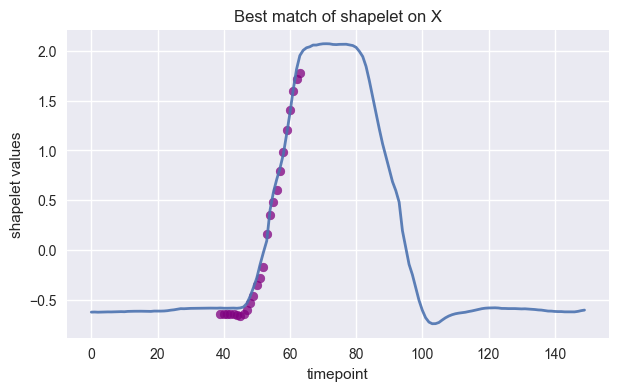

In [23]:
fig = shp_vis.plot_on_X(X_test[1], figure_options={"figsize": (7, 4)})

Or we can visualize the distance between the shapelet $S$ and all subsequences of the same size in $X$. We refer to this as the **distance vector** between $S$ and $X$, and its defined as

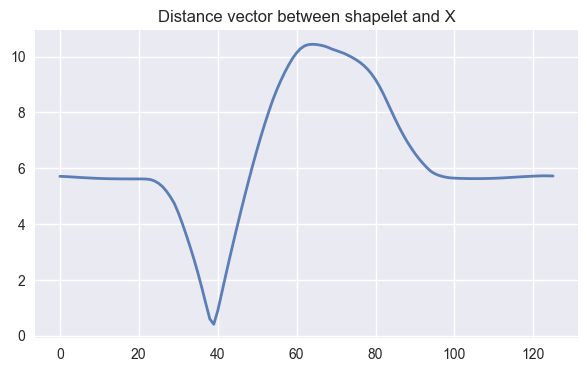

In [24]:
fig = shp_vis.plot_distance_vector(X_test[1], figure_options={"figsize": (7, 4)})

The distance vector graph illustrates the distance between the shapelet and each subsequence based on the starting index of the shapelet as it is slid through. For example, the graph overlapping the shapelet and the best matching subsequence, shows that when the shapelet starts at the 39<sup>th</sup> index the subseries best fits the shapelet. This is also demonstrated in the distance vector graph, where y is minimum at x = 39.

# From Shapelet trees to the Shapelet Transform

A bit later the Shapelet Transform [[2]](https://ueaeprints.uea.ac.uk/id/eprint/40201/1/LinesKDD2012.pdf) was introduced as an alternative to shapelet-based decision trees. Their idea was to use shapelets not as a splitting criterion in a tree, but as a way to extract features from time series, in order to be able to use any kind of tabular classifier. In this method, only one feature was extracted from each time series $X$ and shapelet $S$ : the distance $dist(S,X)$.

Given a set of $k$ shapelets ${\cal S} = [S_1, \ldots, S_k]$, this allows to create an embedding ${\cal X}'$ of a time series dataset ${\cal X} = [X_1, \ldots, X_n]$ such as :

$\displaystyle{{\cal X}' = \begin{bmatrix}
dist(S_1, X_1) & ... & dist(S_k, X_1) \\
... & ... & ... \\
dist(S_1, X_n) & ... & dist(S_k, X_n)
\end{bmatrix}}$

Less formally, the Shapelet Transform creates a table where the rows are the original
 time series and each column is a feature, in this case the (shortest) distance from the shapelet to the time series.

This can be used as a tabular dataset with $k$ features by any tabular classifier. In aeon, every shapelet-based transformation algorithm is following this same reasoning, with some extracting more than one feature per shapelet (for example [RDST](https://www.aeon-toolkit.org/en/latest/api_reference/auto_generated/aeon.transformations.collection.shapelet_based.RandomDilatedShapeletTransform.html), which extract 3 features, giving $3k$ features).

We can list all the available shapelet transformers in aeon by doing the following :




In [25]:
from aeon.utils.discovery import all_estimators

for k, v in all_estimators("transformer", tag_filter={"algorithm_type": "shapelet"}):
    print(f"{k}: {v}")

RSAST: <class 'aeon.transformations.collection.shapelet_based._rsast.RSAST'>
RandomDilatedShapeletTransform: <class 'aeon.transformations.collection.shapelet_based._dilated_shapelet_transform.RandomDilatedShapeletTransform'>
RandomShapeletTransform: <class 'aeon.transformations.collection.shapelet_based._shapelet_transform.RandomShapeletTransform'>
SAST: <class 'aeon.transformations.collection.shapelet_based._sast.SAST'>


Let us, for example, select the `RandomShapeletTransform` transformer, we can use the `fit` and `transform` functions to obtain the time series embdeding :

In [34]:
from aeon.transformations.collection.shapelet_based import RandomShapeletTransform

st = RandomShapeletTransform(max_shapelets=10, n_shapelet_samples=500, random_state=0)
st.fit(X_train, y_train)
st.transform(X_test).shape

(150, 10)

As planned, we obtain a matrix of size $(n,k)$. Given a fitted instance of any shapelet-based transformations, we can use another visualization class to plot the shapelets that were extracted :

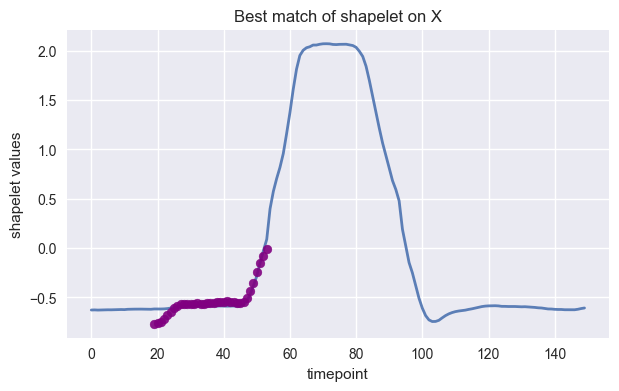

In [35]:
from aeon.visualisation import ShapeletTransformerVisualizer

st_vis = ShapeletTransformerVisualizer(st)
id_shapelet = 0  # Identifier of the shapelet

fig = st_vis.plot_on_X(id_shapelet, X_test[1], figure_options={"figsize": (7, 4)})

You can also create and customize your own shapelet plots with this class, for example :


Text(0.5, 1.0, 'Distance vector of shapelet 0 on X')

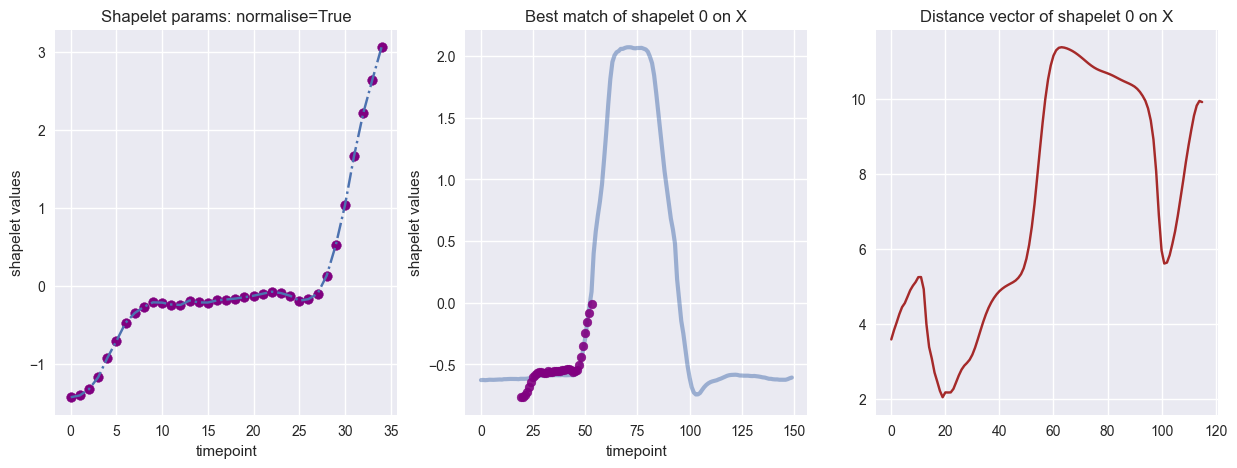

In [36]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(ncols=3, figsize=(15, 5))
st_vis.plot(
    id_shapelet,
    ax=ax[0],
    scatter_options={"c": "purple"},
    line_options={"linestyle": "-."},
)
st_vis.plot_on_X(
    id_shapelet, X_test[1], ax=ax[1], line_options={"linewidth": 3, "alpha": 0.5}
)
ax[1].set_title(f"Best match of shapelet {id_shapelet} on X")
st_vis.plot_distance_vector(
    id_shapelet, X_test[1], ax=ax[2], line_options={"c": "brown"}
)
ax[2].set_title(f"Distance vector of shapelet {id_shapelet} on X")

## Normalized shapelets

Notice how in the above plot, the shapelet values (left-most plot) do not match the ones used to position it on the time series (central plot). This is due to the fact that in `RandomShapeletTransform`, all shapelets use a normalized distance. This has the effect of making the shapelet **scale-invariant**. This means that the best match to the shapelet focuses on the subsequence's **shape**, and is independent to its **scale**. This is the case for most shapelet transformation estimators in aeon. In the `RandomDilatedShapeletTransform` [3], you can tune the `proba_normalization` parameter to modify the probability that a shapelet will be initialized with a normalized distance during `fit`.


To achieve this, both the shapelet values and the subsequences values are z-normalized prior to computing $dist(S,X)$, for example to z-normalize $S$, we first compute $\mu_S$ and $\sigma_S$, respectively the mean and standard deviation of $S$ and obtain its normalized version $\bar{S}$ as :

$\displaystyle{\bar{S} = \frac{(S - \mu_S)}{\sigma_S}}$


# How are shapelets extracted from the time series ?

Now that we understand what shapelets are and how they are used, a question is left unanswered, how do we extract them ? This process is hidden behind the `fit` method of the shapelet-based transformations. We can distinguish x types of shapelet extraction processes:

- **Exhaustive search** : In this case, we extract all possible shapelet candidates (i.e. all subsequences of a given length) and evaluate their quality to select the best ones. For example, after removing self-similar shapelets, we can compute the information gain of a shapelet $S$ based on $dist(S,X) < \lambda$, as done in the shapelet-tree of [1], or as in [2] with the F-statistic of a fixed effects ANOVA.

- **Heuristic-based search**: One issue of the exhaustive search is that it can take a long time to extract and evaluate all shapelet candidates in a dataset. A lot of different approaches are proposed in the literature try to approximate the result of the exhaustive search while minimizing the time needed to obtain the shapelets.
    - For example, instead of evaluating all possible candidates, `RandomShapeletTransform` uses a parameter `n_shapelet_samples` to randomly extract a limited number of shapelets from the input. It then restricts the quality evaluation to these randomly extracted candidates to reduce the search time. It also considers the notion of self-similar shapelets during the candidate extraction to avoid sampling similar shapelets as they would be redundant.
    - Others such as `SAST`[4] only select a small number of "reference" time series in the training data where all subsequences will be considered as shapelets without evaluating their quality. This leaves the "feature selection" step to the classifier that will use the transformation. `RSAST`[5] uses the same approach but also uses some statistical criteria to further reduce the number of candidates extracted from these reference time series.
    - Another approach used in `RandomDilatedShapeletTransform` is to use a semi-random extraction which is guided by a masking of the input space. Once a shapelet has been randomly sampled from a time series, the neighboring points around the sampling point are removed from the list of available sampling points. This avoids extracting self-similar shapelets and improves the diversity of the extracted shapelet set. The number of neighboring points affected by this process is controlled with the `alpha_similarity` parameter.

- **Shapelet generation**: This last approach takes another view at the problem: What if the best shapelets for my dataset are not present in the training data ? The goal is to use optimization methods, such as gradient descent or evolutionary algorithm, to generate shapelet values instead of extracting them from the input. The first shapelet generation method was Learning Shapelet [6], which due to the nature of the extraction, is only implemented as a classifier in aeon inside `LearningShapeletClassifier`.


## Shapelet "self-similarity"
We can visualize the notion of self similarity using the following image. Consider that we sample the shapelet highlighted in green, under self similarity (which is a special case of `alpha_similarity` where `alpha=1`), all the neighboring subsequences, which are stacked and highlighted in red, cannot be considered as shapelet candidates since they would overlap. The next valid candidates would be the ones highlighted in orange since they don't overlap with the green shapelet. The number of pruned candidates is determined by $\alpha \times l$ with $l$ the length of the sampled shapelet (in green).

<img src="img/ex_alpha_sim.png" alt="drawing" width="600"/>

# Shapelet Transform for Classification

Let us recall that given a set of $k$ shapelet ${\cal S} = [S_1, \ldots, S_k]$ extracted from a shapelet transformer during the `fit` method, we create an embedding ${\cal X}'$ of a time series dataset ${\cal X} = [X_1, \ldots, X_n]$ with the `transform` method to obtain:

$\displaystyle{{\cal X}' = \begin{bmatrix}
dist(S_1, X_1) & ... & dist(S_k, X_1) \\
... & ... & ... \\
dist(S_1, X_n) & ... & dist(S_k, X_n)
\end{bmatrix}}$

Knowing how the shapelet transform works, we can now use a classifier on the transformed data to make a classification model. Multiple estimator in `aeon` provide you a classification interface with a `fit` and a `predict` function. The overall shapelet classification framework can be seen in the image below:

<img src="img/shp_general.png" alt="drawing" width="700"/>

 You can obtain the list of available shapelet-estimators with :

For example, using the `ShapeletTransformClassifier`, the `fit` method will extract shapelets, perform the transformation of the data, and by default, train a `RotationForestClassifier` classifier on the transformed data. You can choose which classifier you want to use, either by using the `estimator` parameter, or by building a pipeline yourself from a `RandomShapeletTransform` estimator :

In [38]:
from sklearn.ensemble import RandomForestClassifier

from aeon.classification.shapelet_based import ShapeletTransformClassifier

stc = ShapeletTransformClassifier(
    estimator=RandomForestClassifier(ccp_alpha=0.01), n_shapelet_samples=100
)
stc.fit(X_train, y_train)
stc.score(X_test, y_test)

0.98

Similarly to visualizing transformers, we can also visualize individual shapelets of a shapelet-based classifier, and, when possible, plot the best shapelets based on feature importance criterions of some estimators. The scope of these estimators is generally limited to those inheriting from scikit-learn’s BaseDecisionTree, BaseForest, or LinearClassifierMixin classes, as these are known to be among the most interpretable models where feature weights directly relate to the input features.

For instance, in aeon's Rotational Forest, the application of Principal Component Analysis (PCA) complicates tracing feature importance back to individual shapelets. Since PCA transforms the original feature space into a new set of uncorrelated components, it becomes difficult to directly associate these components with the original shapelet features, reducing the interpretability in terms of feature importance.

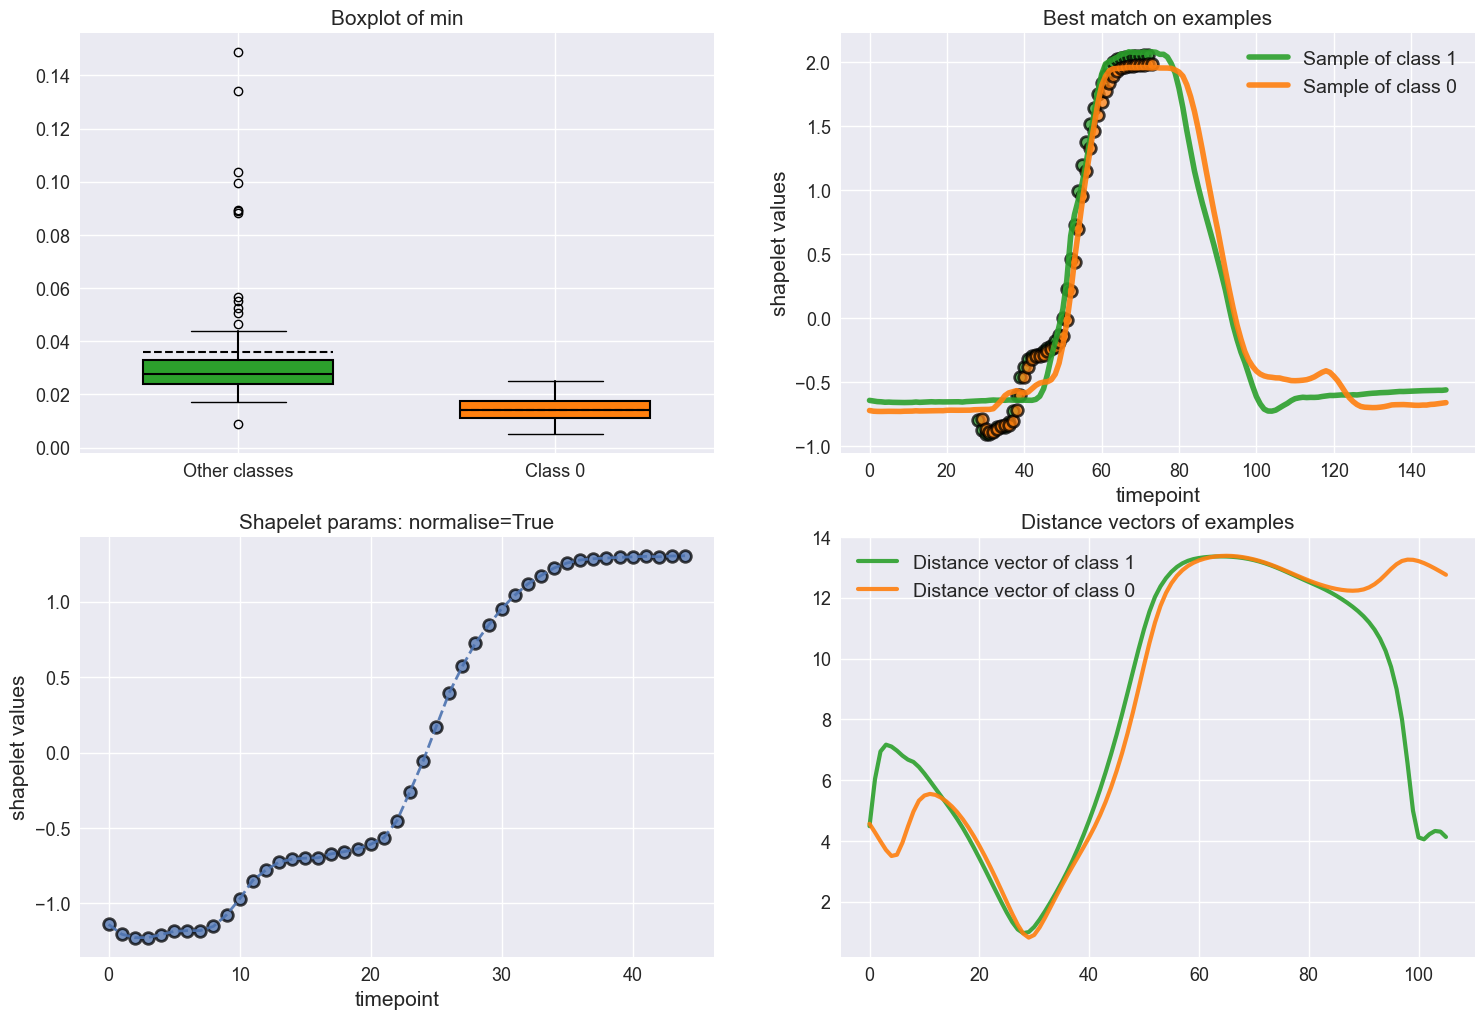

In [39]:
from aeon.visualisation import ShapeletClassifierVisualizer

stc_vis = ShapeletClassifierVisualizer(stc)
id_class = 0
fig = stc_vis.visualize_shapelets_one_class(
    X_test,
    y_test,
    id_class,
    figure_options={"figsize": (18, 12), "nrows": 2, "ncols": 2},
)

The four graphs each aid in the interpretability of shapelet-based algorithms. Here we take the most discriminating shapelet of class 0 and explore it for both local and global patterns.

- Boxplot of Min (Top Left): This graph introduces a new perspective by focusing on a global quality of the shapelet. It shows the distribution of the minimum distances between the shapelet and each time series across different classes. As expected, the shapelet fits class 0 more closely than the other classes.

- Best Match on Examples (Top Right): This graph extends the best match visualization by showing how the shapelet fits a random time series from each class. The green and orange curves represent samples from classes 1 and 0, respectively. The shapelet should, and does, align more closely with the organge time series of class 0, illustrating its effectiveness in distinguishing between the two classes according to a local pattern.

- Shapelet Params (Bottom Left): This graph, already introduced, elegantly displays the shapelet's pattern over time.

- Distance Vectors of Examples (Bottom Right): This graph is an extension of the distance vector visualization, offering a comparison of how well the shapelet fits the two time series, from the 'Best Match on Examples' graph, at each point. This allows for a global understanding of how well the shapelet fits a time series at any point.

## Dilated shapelets

Dilated shapelets [3] modify the formulation of the distance function $dist(S,X)$, by adding a dilation parameter $\mathbf{d}$ to $S$, working similarly to dilation in convolutional kernels. The goal of this parameter is two-fold :
- Increase the receptive field of the shapelet, by allowing it to span across $l\times \mathbf{d}$ points while only needing $l$ values.
- The fact we only need $l$ instead of $l\times \mathbf{d}$ to compute $dist(S,X)$ with an equivalent receptive field is also an advantage to avoid the curse of dimensionality (i.e. the more points we compare in a distance, the greater the possibility of an equivalent results for widely different inputs given the same).

The distance formulation, which is equivalent to the classic one when $\mathbf{d}=1$, is then :

$\displaystyle{dist(S,X) = \min\limits_{i\ :1, \ldots, m-(l\times \mathbf{d})} \sqrt{\sum_{j=0}^{l-1}(\mathbf{s}_j - \mathbf{x}_{i+(j\times \mathbf{d})})^2}}$

Which then for $\mathbf{d}=2$ can be illustrated as :

<img src="img/ex_dil_shp_slide.png" alt="drawing" width="500"/>

Note that `RDST` uses the manhattan distance instead of the euclidean distance.

## Extracting more features from the distance vector

The distance vector $V = [v_1, \ldots, v_{m-(l\times \mathbf{d})}]$ with $v_i = \sqrt{\sum_{j=0}^{l-1}(\mathbf{s}_j - \mathbf{x}_{i+(j\times \mathbf{d})})^2}$ (here with euclidean distance), contains all the distances between $S$ and the candidate subsequences in $X$ (subsequence of the same length, including dilation). While most shapelet-based transformers and classifiers in aeon only extract the minimum value from $V$, in `RandomDilatedShapeletTransform`, two more features are extracted :

- $\text{argmin} V$ : the location of the best match, where the location is the position of the front of the shapelet
- $\sum_i I(v_i < \lambda)$ : the shapelet occurrence feature, which counts how many times $S$ was $\lambda$-close to $X$ (with $I$ the identity function).

These features allow us to use shapelets to discriminate, and as  `RandomDilatedShapeletTransform` also make use of normalized and non-normalized shapelets, we can distinguish the following cases :

<img src="img/class_diff.png" alt="drawing" width="800"/>

## Generalization to the multivariate case

The case of multivariate shapelets is a matter of adapting the distance function $dist(S,X)$ to the multivariate case. This boils down to a question of  whether to use a channel dependent or channel independent distance. In the dependent one, the distance is considering multiple channels, while in the independent approach, we apply a univariate distance to all the channels and sum the distance vectors of each channel together. This choice is specific to the nature of the data and of the distance function.

For example if we use dynamic time warping (DTW), this would mean that we either search a warping path that include all channels, or search warping paths independently for each channel. But if we were using a **squared** euclidean distance (where we don't use the square root), both options would be equivalent.

For now only `RDSTClassifier` and  `ShapeletTransformClassifier` (and their respective transform) support multivariate inputs. Another thing that can change in the multivariate case, is that a shapelet $S$ may only consider a subset of the channels when computing the distance (this adds a parameter to $S$ which is a boolean mask to indicate which channel is used). This was used in the original implementation of `RDSTClassifier`, but it is not present in the `aeon` implementation for the moment.

## Generalization to the unequal length case

In this case, the only adaptation needed is to make sure that shapelets are not longer than any of the time series we use as input. Otherwise, this is more of an implementation problem, as theoretically, there is no issue with computing distance vectors with a shapelet and different sized time series.

**One point of attention in this case will be on the feature extracted**. Notably with `RDSTClassifier`, as both the `argmin` and the `ShapeletOccurence` features will be affected by varying time series length, it is up to the user to decide whether these feature should be normalized by the length of the time series from which they are extracted (e.g. `argmin/m_i`, with $m_i$ the length of time series $X_i$). If not normalized, these features could encode some information about time series length, and thus bias the classifier if this information is irrelevant.


## SAST Example

The `SASTClassifier` [4] is a pipeline shapelet based classifier we can use for
further visualisation examples.


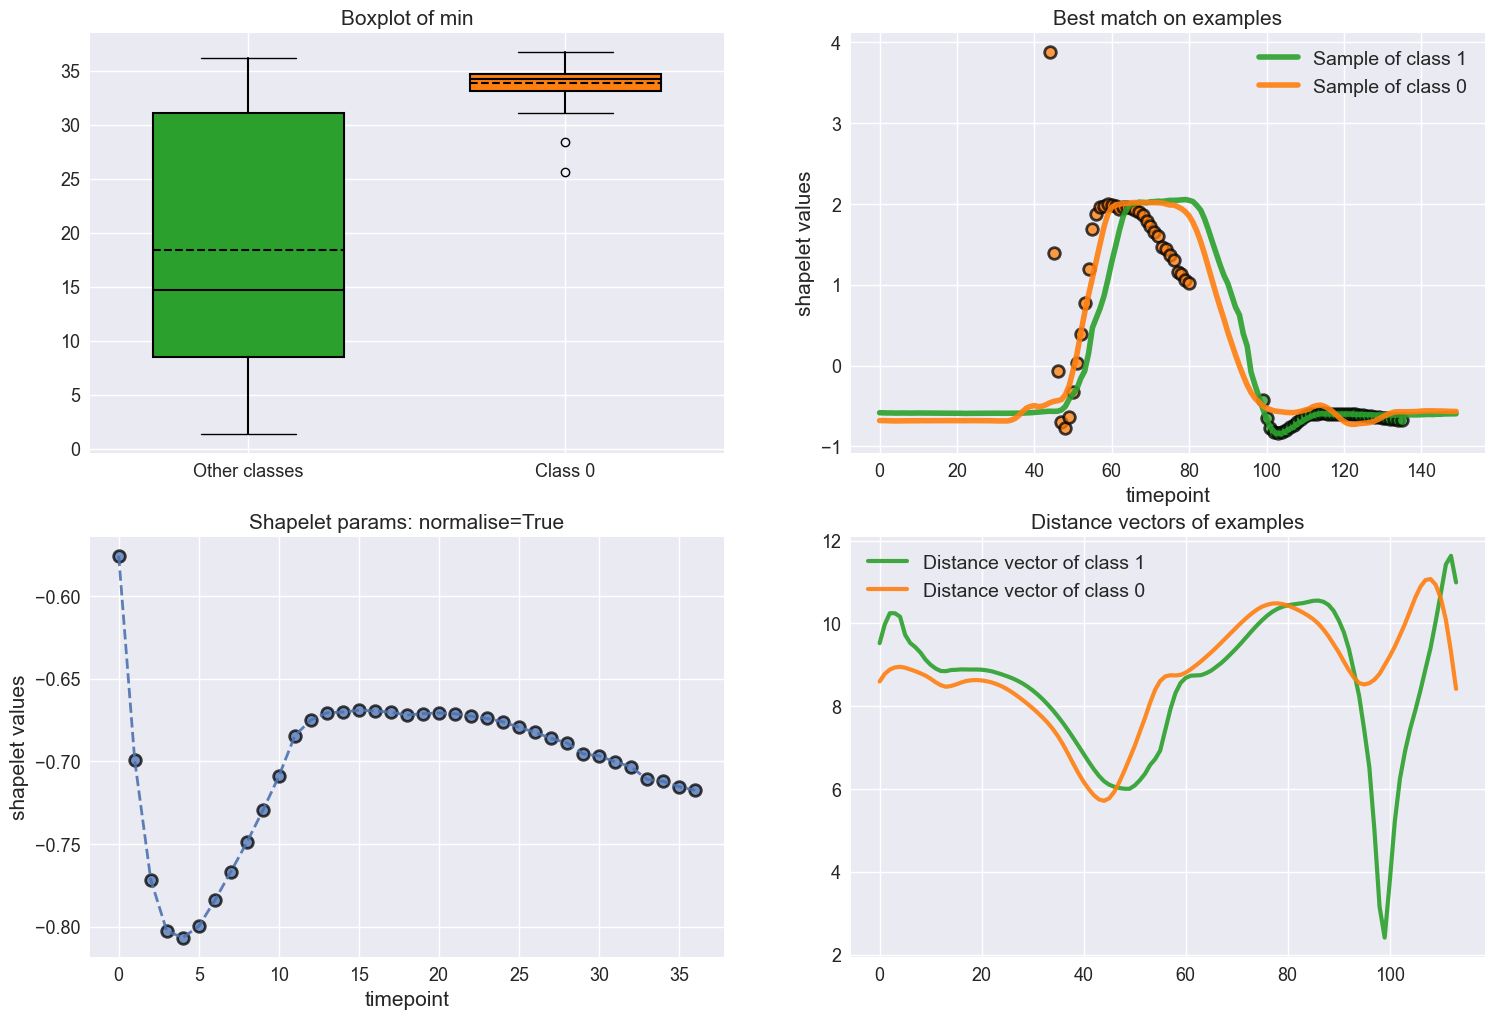

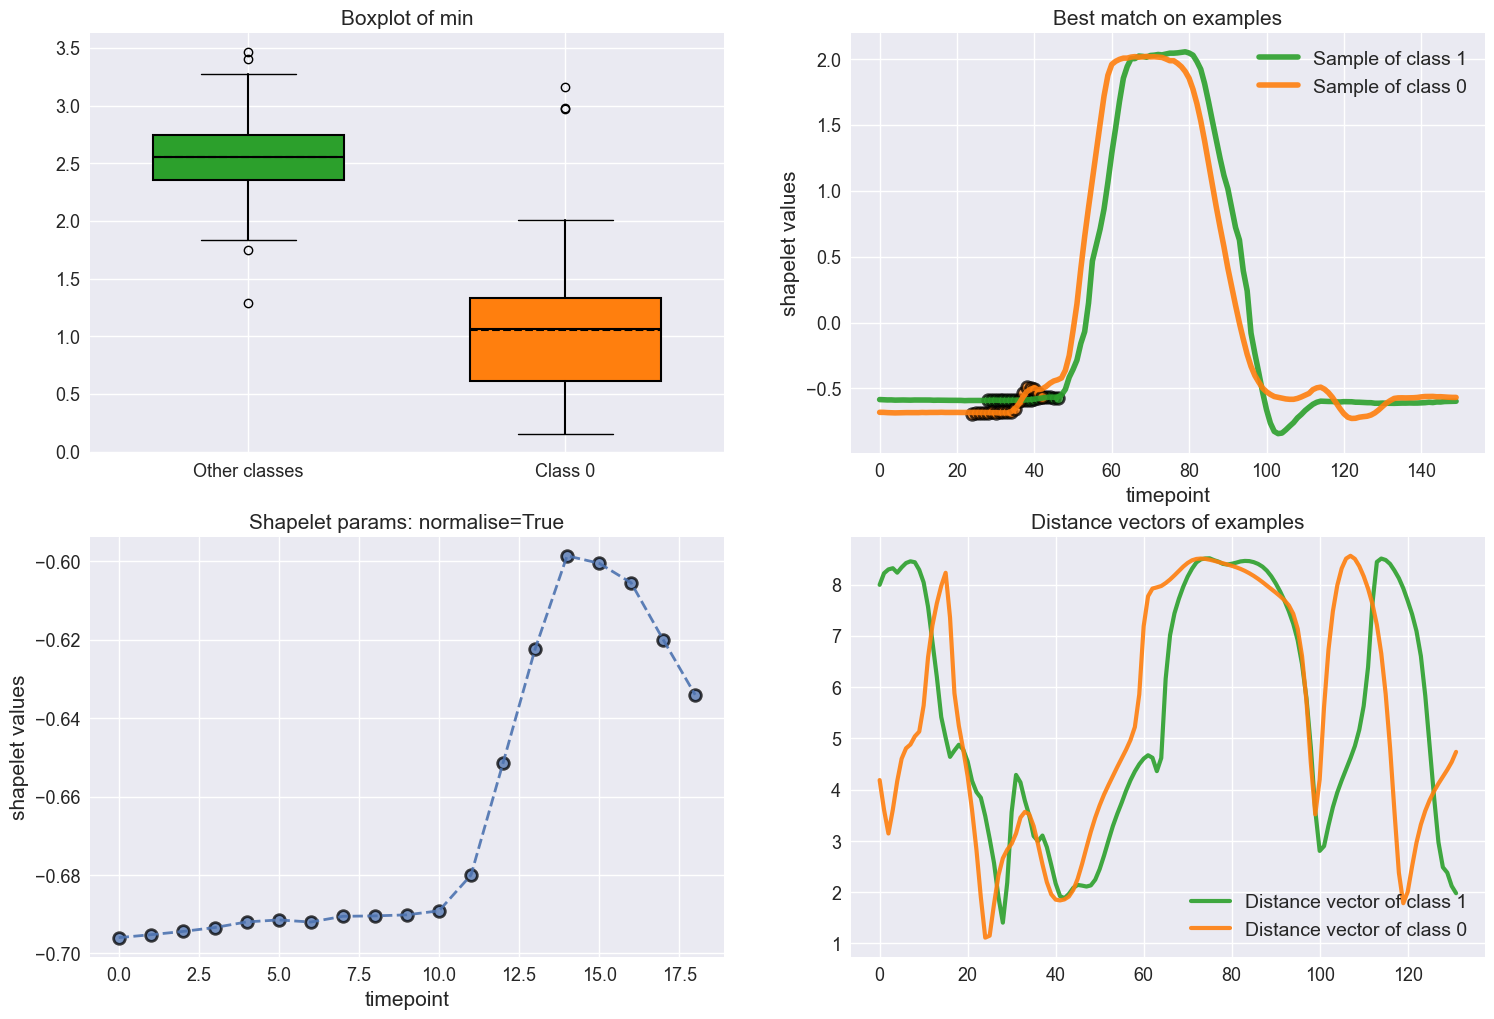

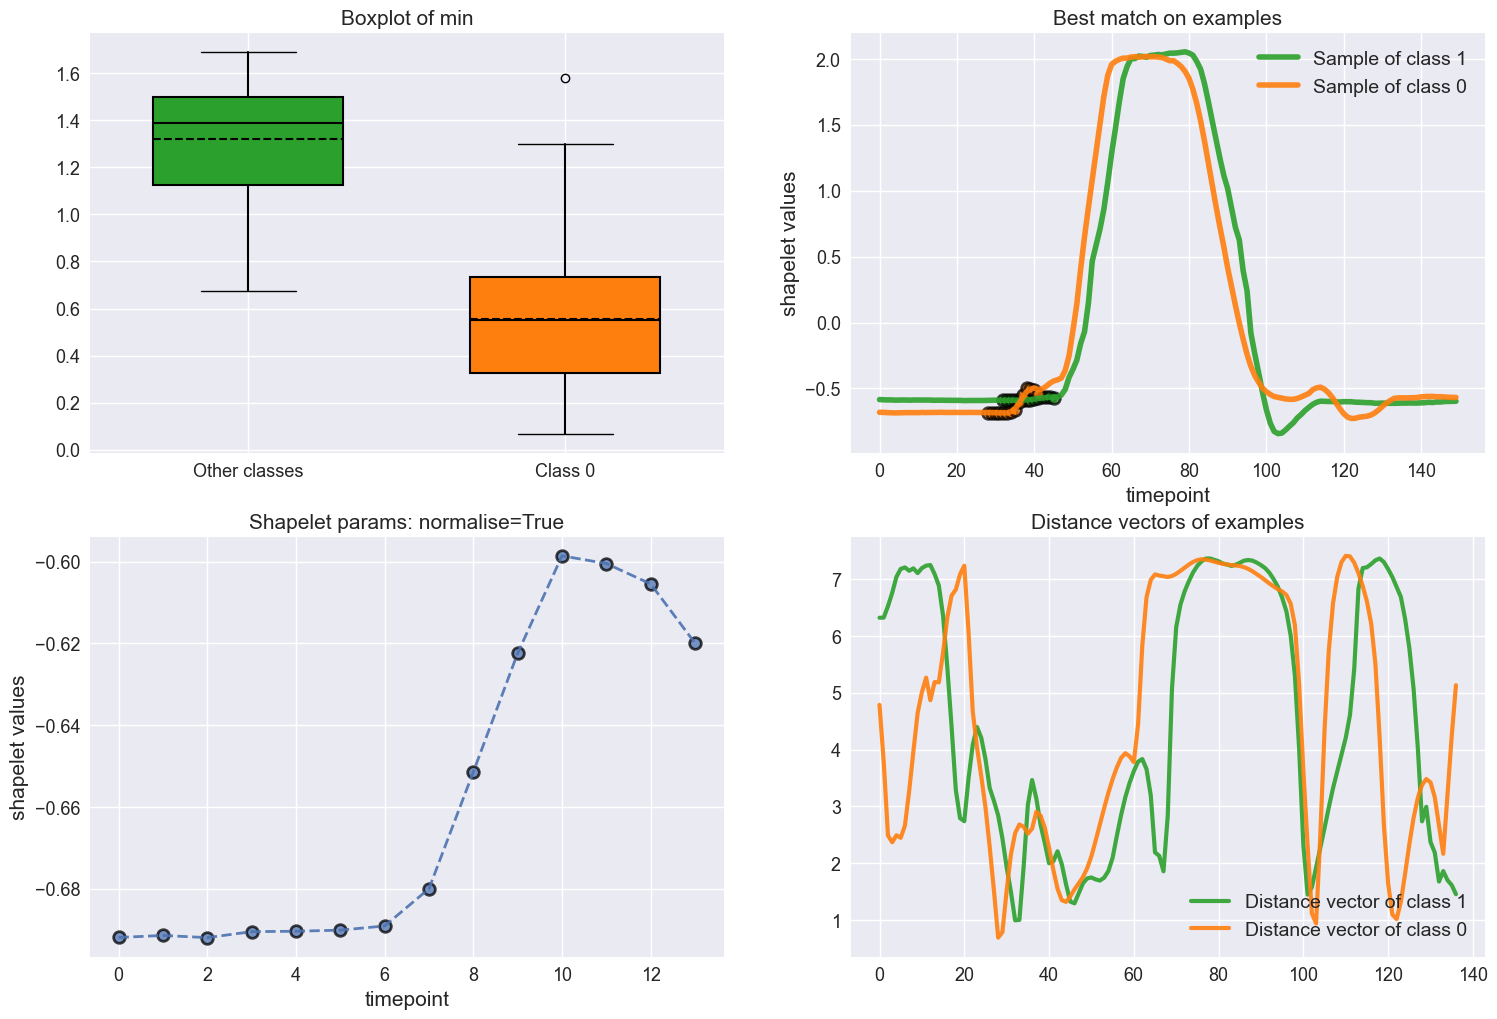

In [40]:
from sklearn.ensemble import RandomForestClassifier

from aeon.classification.shapelet_based import SASTClassifier

stc = SASTClassifier(classifier=RandomForestClassifier(ccp_alpha=0.01)).fit(
    X_train, y_train
)
from aeon.visualisation import ShapeletClassifierVisualizer

stc_vis = ShapeletClassifierVisualizer(stc)
id_class = 0
fig = stc_vis.visualize_shapelets_one_class(
    X_test,
    y_test,
    id_class,
    n_shp=3,
    figure_options={"figsize": (18, 12), "nrows": 2, "ncols": 2},
)

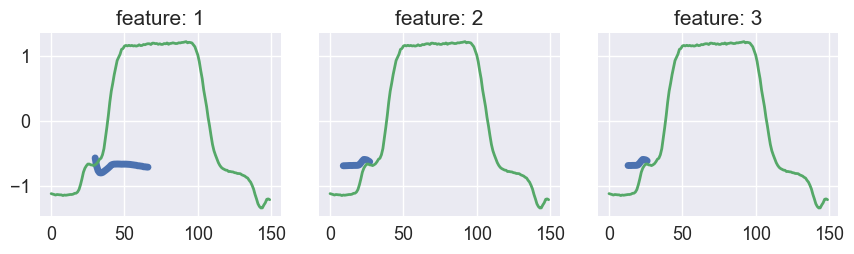

In [41]:
weights = stc._classifier.feature_importances_
fig = stc.plot_most_important_feature_on_ts(X_test[0][0], weights, 3)

## Performance on the UCR univariate datasets

Our current shapelet classifiers are in the directory `aeon.classification.shapelet_based`. We currently only have reference results for three of these.

In [42]:
all_shapelet_classifiers = [
    "MrSQMClassifier",
    "ShapeletTransformClassifier",
    "RDSTClassifier",
    "SASTClassifier",
    "RSASTClassifier",
    "LearningShapeletClassifier",
]
from aeon.benchmarking.results_loaders import get_estimator_results_as_array
from aeon.datasets.tsc_datasets import univariate

est = ["MrSQMClassifier", "RDSTClassifier", "ShapeletTransformClassifier"]
names = [t.replace("Classifier", "") for t in est]
results, present_names = get_estimator_results_as_array(
    names, univariate, include_missing=False
)
results.shape

(112, 3)

(<Figure size 600x220 with 1 Axes>, <Axes: >)

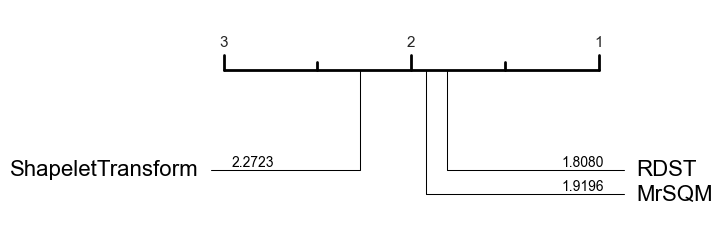

In [43]:
from aeon.visualisation import plot_boxplot, plot_critical_difference

plot_critical_difference(results, names)

(<Figure size 1000x600 with 1 Axes>, <Axes: >)

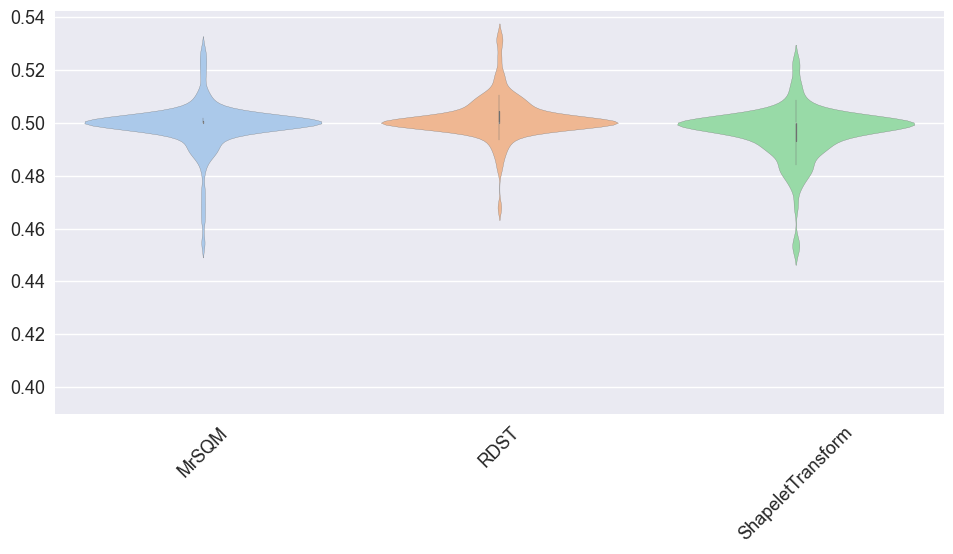

In [44]:
plot_boxplot(results, names, relative=True)

## References

[1] L. Ye and E. Keogh. Time series shapelets: A new primitive for data mining. In
Proc. 15th ACM SIGKDD, 2009 (https://www.cs.ucr.edu/~eamonn/shaplet.pdf)

[2] J. Lines et al. A shapelet transform for time series classification. In Proc. 18th ACM SIGKDD, 2012.

[3] Antoine Guillaume et al. Random Dilated Shapelet Transform: A New Approach  for Time Series Shapelet. ICPRAI 2021.

[4] Mbouopda, Michael Franklin, and Engelbert Mephu Nguifo. Scalable and accurate subsequence transform for time series classification. Pattern Recognition 147, 2023.

[5] Varela, N. R., Mbouopda, M. F., & Nguifo, E. M. RSAST: Sampling  Shapelets for 
Time Series Classification. 2023.

[6] Grabocka, J. et al.  Learning time-series shapelets. In Pro.e 20th ACM SIGKD, 2014.).
